<a href="https://colab.research.google.com/github/bghjmn32/Castle-Black/blob/master/%E2%80%9Copt7_Hongyi_LUO_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing the necessary libraries

import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
import pandas as pd
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

sns.set()

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# These are some useful functions from previous labs

# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    if tolower:
        string = string.lower()
    return string.strip()
    #return string


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline() #loading the first line of file

    cpt=1
    skip=0
    firstcleanline = clean_str(line)
    dataset.append(line)
    while line :
        everyline=clean_str(f.readline())
        #print(everyline)

        dataset.append(everyline)
        cpt+=1
        if limit > 0 and cpt >= limit: 
            break        
    f.close()
    #print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


## Step 1: Importing data

We have stored the dataset in Google Drive, which has easy integration with Google Colab, which we are using due to its free available computation power that is much greater than our own systems.

In [0]:
# Setting the path to the dataset file

import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/OPT7 Project_Eva_Robin_Hongyi/Data"

#just to test the connection works
os.chdir(path)
#os.listdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
100k_data_sampled.csv  data_df.csv	    processRaw-1.py
50k_data_sampled.csv   data_sampled.csv     review_text_clean.csv
beeradvocate.txt       df_with_POStags.csv  tokenized_text.csv
Clean_dataset.csv      new_df.csv


In [0]:
LIM= 22212596 #This number is a precise boundary I choose with editor by hand from file.

txtfile = "beeradvocate.txt"  
beeradvocate = loadTexts(txtfile,limit=LIM)

In [0]:
# To give an example for what the dataset looks like

beeradvocate[0] = beeradvocate[0]
beeradvocate[0:27]

['beer/name: Sausa Weizen\n',
 'beer/beerid: 47986',
 'beer/brewerid: 10325',
 'beer/abv: 5.00',
 'beer/style: hefeweizen',
 'review/appearance: 2.5',
 'review/aroma: 2',
 'review/palate: 1.5',
 'review/taste: 1.5',
 'review/overall: 1.5',
 'review/time: 1234817823',
 'review/profilename: stcules',
 'review/text: a lot of foam. but a lot.\tin the smell some banana, and then lactic and tart. not a good start.\tquite dark orange in color, with a lively carbonation (now visible, under the foam).\tagain tending to lactic sourness.\tsame for the taste. with some yeast and banana.',
 '',
 'beer/name: red moon',
 'beer/beerid: 48213',
 'beer/brewerid: 10325',
 'beer/abv: 6.20',
 'beer/style: english strong ale',
 'review/appearance: 3',
 'review/aroma: 2.5',
 'review/palate: 3',
 'review/taste: 3',
 'review/overall: 3',
 'review/time: 1235915097',
 'review/profilename: stcules',
 'review/text: dark red color, light beige foam, average.\tin the smell malt and caramel, not really light.\tagain 

As is visible from the cell above, the dataset is still quite unorganised. The elements we want (scores and the text) are in different lines of the dataset now, so that should be fixed. This is done in the cell below, which also immediately deletes the "review/overall: " and similar parts so that we only have the numbers of the review score in the end. The scores are then put in a pandas dataframe for easier analysis later.

In [0]:
review_text=[]

for i in range(12,22212596,14):
  temp = beeradvocate[i]
  review_text.append(temp)

#getting 5 kinds of scores

def extract_number(string):
  """
  This function only extracts the review score from the input string and 
  deletes the rest.
  """
  searchObj = re.search( r'\d{1,}'+'\.{0,}'+'\d{0,}', string)
  return float(searchObj.group())

review_overall_label=[]

for i in range(9,22212596,14):
  review_overall_label.append(extract_number(beeradvocate[i]))

review_overall_label_df = pd.DataFrame(review_overall_label, columns=['Overall Score'])

review_taste_label=[]

for i in range(8,22212596,14):
  review_taste_label.append(extract_number(beeradvocate[i]))

review_taste_label_df = pd.DataFrame(review_taste_label, columns=['Taste Score'])

review_palate_label=[]

for i in range(7,22212596,14):
  review_palate_label.append(extract_number(beeradvocate[i]))

review_palate_label_df = pd.DataFrame(review_palate_label, columns=['Palate Score'])

review_aroma_label=[]

for i in range(6,22212596,14):
  review_aroma_label.append(extract_number(beeradvocate[i]))

review_aroma_label_df = pd.DataFrame(review_aroma_label, columns=['Aroma Score'])

review_appearance_label=[]

for i in range(5,22212596,14):
  review_appearance_label.append(extract_number(beeradvocate[i]))

review_appearance_label_df = pd.DataFrame(review_appearance_label, columns=['Appearance Score'])


Now that the scores for the different aspects are separate dataframes, they should be combined into one pandas dataframe, which is what the code below takes care of.

In [0]:
data_df = pd.concat([review_overall_label_df, 
                        review_taste_label_df, 
                        review_palate_label_df,
                        review_aroma_label_df,
                        review_appearance_label_df], axis=1)

data_df

,Overall Score,Taste Score,Palate Score,Aroma Score,Appearance Score
0,1.5,1.5,1.5,2.0,2.5
1,3.0,3.0,3.0,2.5,3.0
2,3.0,3.0,3.0,2.5,3.0
3,3.0,3.0,2.5,3.0,3.5
4,4.0,4.5,4.0,4.5,4.0
...,...,...,...,...,...
1586609,5.0,4.0,4.0,4.0,3.5
1586610,4.0,4.0,2.0,5.0,2.5
1586611,4.5,4.0,3.5,3.5,3.0
1586612,4.0,4.5,4.5,4.5,4.5


In [0]:
review_text[0:100]

['review/text: a lot of foam. but a lot.\tin the smell some banana, and then lactic and tart. not a good start.\tquite dark orange in color, with a lively carbonation (now visible, under the foam).\tagain tending to lactic sourness.\tsame for the taste. with some yeast and banana.',
 'review/text: dark red color, light beige foam, average.\tin the smell malt and caramel, not really light.\tagain malt and caramel in the taste, not bad in the end.\tmaybe a note of honey in teh back, and a light fruitiness.\taverage body.\tin the aftertaste a light bitterness, with the malt and red fruit.\tnothing exceptional, but not bad, drinkable beer.',
 'review/text: almost totally black. beige foam, quite compact, not bad.\tlight smell, just a bit of roast, and some hop. a bit too light.\tthe taste is light oo, and drinkable, with some malt, roast, hints of coffee.\tnothing exceptional, but after all drinkable and pleasant.\tlight to average body.\tin the aftertaste some dust, somr roast, hint of ca

In [0]:
# clean the data 
def clean_text(string):
    """
    This function cleans the input string from punctuation and other elements
    that are unwanted in the review text for analysis.
    """
    temp = string
    temp = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", temp)
    temp = re.sub(r"\'s", " \'s", temp)
    temp = re.sub(r"\'ve", " \'ve", temp)
    temp = re.sub(r"\'re", " \'re", temp)
    temp = re.sub(r"\'d", " \'d", temp)
    temp = re.sub(r"\'ll", " \'ll", temp)
    temp = re.sub(r",", " , ", temp)
    temp = re.sub(r"!", " ! ", temp)
    temp = re.sub(r"\(", " \( ", temp)
    temp = re.sub(r"\)", " \) ", temp)
    temp = re.sub(r"\?", " \? ", temp)
    temp = temp.replace('review text','')
    temp = temp.replace("?","")
    temp = temp.replace('\t','')
    temp = temp.replace('review/text:','')
    temp = temp.replace(',','') 
    temp = temp.replace('.','')
    temp = temp.replace('(','')
    temp = temp.replace(')','')
    temp = temp.replace("?","")
    temp = temp.replace('/','')
    temp = temp.replace('-','')
    temp = temp.replace('!','')
    temp = temp.replace('&','')
    temp = temp.replace('*','')
    temp = temp.replace('$','')
    temp = temp.replace('#','')
    temp = temp.replace('@','')
    temp = temp.replace("'","")
    temp = temp.replace("\\", " ")
    temp = re.sub(r"\s{2,}", " ", temp)
    return temp

review_text_clean = []

for i in range(len(review_text)):
    review_text_clean.append(clean_text(review_text[i]))



In [0]:
del beeradvocate
del review_overall_label
del review_taste_label
del review_palate_label
del review_aroma_label
del review_appearance_label
del review_overall_label_df
del review_taste_label_df
del review_palate_label_df
del review_aroma_label_df
del review_appearance_label_df
del review_text

import gc

gc.collect()
gc.collect()

0

In [0]:
#review_text_clean_pd = pd.DataFrame(review_text_clean, columns=['Review text'])

In [0]:
#new_df = pd.concat([review_text_clean_pd, data_df], axis=1)

In [0]:
#new_df.to_csv('new_df.csv', index=False)

In [0]:
#new_df = pd.read_csv('new_df.csv')

To make sure the models do not take ages to run, we decided to randomly sample the data.

In [0]:
#sample_data_50k = new_df.sample(n=50000, random_state=42).reset_index(drop=True)
#sample_data_100k = new_df.sample(n=100000, random_state=42).reset_index(drop=True)

In [0]:
#sample_data_50k.to_csv('50k_data_sampled.csv', index=False)
#sample_data_100k.to_csv('100k_data_sampled.csv', index=False)

In [0]:
#sample_data_50k = pd.read_csv('50k_data_sampled.csv').reset_index(drop=True)
#sample_data_100k = pd.read_csv('100k_data_sampled.csv').reset_index(drop=True)

In [0]:
tokenizer = ToktokTokenizer()

sample_data_50k['Tokenized Text'] = sample_data_50k['Review text'].apply(tokenizer.tokenize)

sample_data_50k = sample_data_50k.drop(['Review text'], axis=1)

In [0]:
#sample_data_50k.to_csv('Clean_dataset.csv', index=False)

### Run from here for reduced runtime

In [0]:
df = pd.read_csv('Clean_dataset.csv')

In [0]:
df

,Overall Score,Taste Score,Palate Score,Aroma Score,Appearance Score,Tokenized Text
0,4.0,4.0,4.0,4.5,4.0,"['on', 'tap', 'at', 'the', 'brick', 'store', '..."
1,3.5,2.5,3.5,2.5,3.0,"['very', 'underachieving', 'dont', 'find', 'ma..."
2,2.5,2.5,2.5,3.0,3.5,"['blind', 'tasting', 'at', 'my', 'brother', 'i..."
3,2.5,2.0,2.5,2.0,3.5,"['the', 'beer', 'board', 'claims', 'this', 'is..."
4,4.5,4.0,4.5,4.5,5.0,"['this', 'was', 'purchased', 'as', 'a', 'singl..."
...,...,...,...,...,...,...
49995,3.5,3.5,4.0,3.0,4.0,"['16', '09oz', 'dark', 'brown', 'bottle', 'dat..."
49996,3.5,3.5,3.5,3.5,2.5,"['the', 'typical', '22', 'ounce', 'bottle', 'p..."
49997,5.0,5.0,4.0,4.0,4.5,"['this', 'is', 'one', 'of', 'the', 'more', 'un..."
49998,3.0,4.0,4.5,3.5,4.0,"['pour', 'is', 'super', 'deep', 'brown', 'with..."


In [0]:
df['Tokenized Text'] = df['Tokenized Text'].str.split(',')

In [0]:
df_test = df['Tokenized Text'].iloc[0:20]

In [0]:
df_test_tags = df_test.apply(nltk.pos_tag)
df_test_tags

0     [(['on', JJ), ( 'tap', NNP), ( 'at', NNP), ( '...
1     [(['very', JJ), ( 'underachieving', NNP), ( 'd...
2     [(['blind', JJ), ( 'tasting', NNP), ( 'at', NN...
3     [(['the', JJ), ( 'beer', NNP), ( 'board', NNP)...
4     [(['this', JJ), ( 'was', NNP), ( 'purchased', ...
5     [(['a', JJ), ( 'clear', NNP), ( 'brown', NNP),...
6     [(['here', JJ), ( 's', NNP), ( 'the', NNP), ( ...
7     [(['this', JJ), ( 'poured', NNP), ( 'nicely', ...
8     [(['pours', JJ), ( 'a', NNP), ( 'pretty', NNP)...
9     [(['batch', JJ), ( '436', NNP), ( '437', NNP),...
10    [(['a', JJ), ( 'pale', NNP), ( 'wheat', NNP), ...
11    [(['this', JJ), ( 'poured', NNP), ( 'a', NNP),...
12    [(['bottled', JJ), ( '2', NNP), ( 'april', NNP...
13    [(['poured', JJ), ( 'form', NNP), ( 'a', NNP),...
14    [(['had', JJ), ( 'this', NNP), ( 'one', NNP), ...
15    [(['12', JJ), ( 'oz', NNP), ( 'bottle', NNP), ...
16    [(['a', JJ), ( 'reddish', NNP), ( 'amber', NNP...
17    [(['dark', JJ), ( 'appearance', NNP), ( 'w

In [0]:
df['POS tags'] = df['Tokenized Text'].apply(nltk.pos_tag)

In [0]:
df

,Overall Score,Taste Score,Palate Score,Aroma Score,Appearance Score,Tokenized Text,POS tags
0,4.0,4.0,4.0,4.5,4.0,"[['on', 'tap', 'at', 'the', 'brick', 'sto...","[(['on', JJ), ( 'tap', NNP), ( 'at', NNP), ( '..."
1,3.5,2.5,3.5,2.5,3.0,"[['very', 'underachieving', 'dont', 'find',...","[(['very', JJ), ( 'underachieving', NNP), ( 'd..."
2,2.5,2.5,2.5,3.0,3.5,"[['blind', 'tasting', 'at', 'my', 'brother...","[(['blind', JJ), ( 'tasting', NNP), ( 'at', NN..."
3,2.5,2.0,2.5,2.0,3.5,"[['the', 'beer', 'board', 'claims', 'this'...","[(['the', JJ), ( 'beer', NNP), ( 'board', NNP)..."
4,4.5,4.0,4.5,4.5,5.0,"[['this', 'was', 'purchased', 'as', 'a', ...","[(['this', JJ), ( 'was', NNP), ( 'purchased', ..."
...,...,...,...,...,...,...,...
49995,3.5,3.5,4.0,3.0,4.0,"[['16', '09oz', 'dark', 'brown', 'bottle',...","[(['16', JJ), ( '09oz', NNP), ( 'dark', NNP), ..."
49996,3.5,3.5,3.5,3.5,2.5,"[['the', 'typical', '22', 'ounce', 'bottle...","[(['the', JJ), ( 'typical', NNP), ( '22', NNP)..."
49997,5.0,5.0,4.0,4.0,4.5,"[['this', 'is', 'one', 'of', 'the', 'more...","[(['this', JJ), ( 'is', NNP), ( 'one', NNP), (..."
49998,3.0,4.0,4.5,3.5,4.0,"[['pour', 'is', 'super', 'deep', 'brown', ...","[(['pour', JJ), ( 'is', NNP), ( 'super', NNP),..."


In [0]:
df.to_csv('df_with_POStags.csv', index=False)

In [0]:
from collections import Counter
import nltk
counts = Counter( tag for word,  tag in df['POS tags'][120])
print(counts)

Counter({'NNP': 164, 'JJ': 1, 'NN': 1})


As we can see here, the POS tagging didn't go as well as we wanted it to. Therefore, we have decided to go on without the POS tags for now, leaving it to be added in a potential future.

## Data Exploration

Now that we have prepared the data, it's time for some data exploration. The things we decided to explore are the following:

- Distribution of scores of the different aspects of the rating
- Correlation between review length and overall rating
- Correlation between the different scores


Options:

Some other points could be - 1.) correlation between
review length and overall rating 2.) number of adjectives
vs the overall rating 

Text(0, 0.5, '# Datapoints')

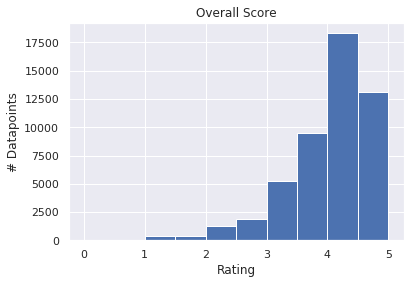

In [0]:
df['Overall Score'].hist(bins=10)
plt.title('Overall Score')
plt.xlabel('Rating')
plt.ylabel('# Datapoints')

Text(0, 0.5, '# Datapoints')

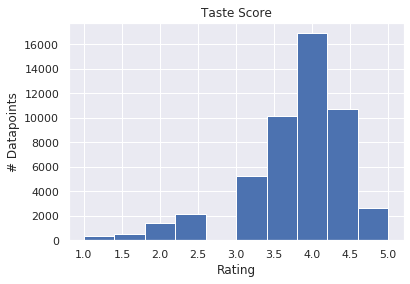

In [0]:
df['Taste Score'].hist(bins=10)
plt.title('Taste Score')
plt.xlabel('Rating')
plt.ylabel('# Datapoints')

Text(0, 0.5, '# Datapoints')

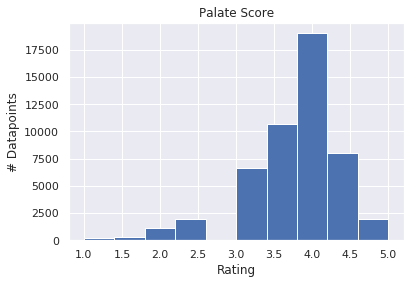

In [0]:
df['Palate Score'].hist(bins=10)
plt.title('Palate Score')
plt.xlabel('Rating')
plt.ylabel('# Datapoints')

Text(0, 0.5, '# Datapoints')

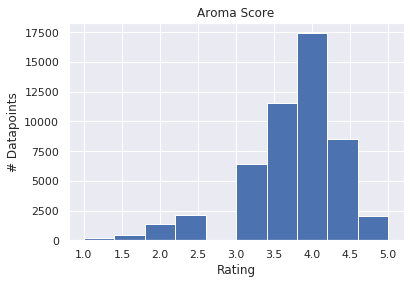

In [0]:
df['Aroma Score'].hist(bins=10)
plt.title('Aroma Score')
plt.xlabel('Rating')
plt.ylabel('# Datapoints')

Text(0, 0.5, '# Datapoints')

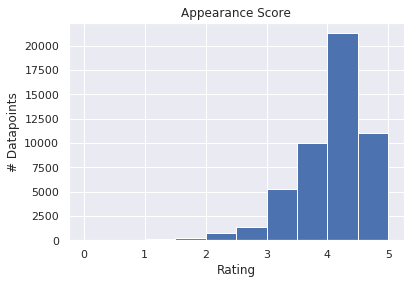

In [0]:
df['Appearance Score'].hist(bins=10)
plt.title('Appearance Score')
plt.xlabel('Rating')
plt.ylabel('# Datapoints')

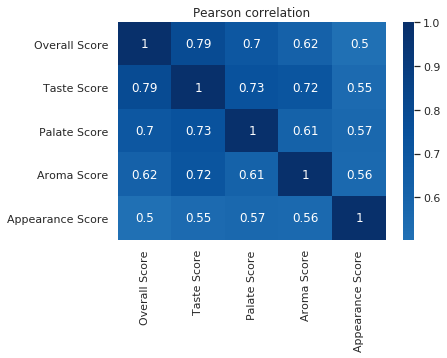

In [0]:
corr_mat = df[['Overall Score', 'Taste Score', 'Palate Score', 'Aroma Score', 'Appearance Score']].corr(method='pearson')
sns.heatmap(abs(corr_mat), annot=True, center=0, cmap="Blues")
plt.title('Pearson correlation')
plt.show()

## Splitting the dataset for analysis

Now that we have explored the data and we have seen some of its characteristics, we should split the dataset in a train, development, and test set. 

We split the dataset as follows:
- 70% Training set
- 15% Development set
- 15% Test set

We decided to maintain two sets of the split results, one with the scores for the attributes of the experience, and one without. This to see the impact of the scores on performance. By using the same random_state, the indexes in both versions will be the same, making analysis easier.

In [0]:
labels = df['Overall Score']

trainset_withscores = df.drop(columns=['Overall Score'])
trainset_withoutscores = df['Tokenized Text']

In [0]:
def split_sets(trainset, labels, test_size=0.15, dev_size=0.15):
    X_traindev, X_test, y_traindev, y_test = train_test_split(trainset,
                                                         labels,
                                                         test_size=test_size,
                                                         random_state=42,
                                                         stratify=None)

    X_train, X_dev, y_train, y_dev = train_test_split(X_traindev,
                                                  y_traindev,
                                                  test_size=dev_size/(1-test_size),
                                                  random_state=42,
                                                  stratify=None)   

    return X_train, y_train, X_dev, y_dev, X_test, y_test 

In [0]:
X_train_withscores, y_train_withscores, X_dev_withscores, y_dev_withscores, X_test_withscores, y_test_withscores = split_sets(trainset_withscores, 
                                                                                                                              labels)

In [0]:
X_train_withoutscores, y_train_withoutscores, X_dev_withoutscores, y_dev_withoutscores, X_test_withoutscores, y_test_withoutscores = split_sets(trainset_withoutscores, 
                                                                                                                              labels)

Now that the data has been split, it can be prepared for the models that it will be fed into. We use Tfidf vectors as the representation.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

In [0]:
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [0]:
X_train_withscores_tfidf = tfidf.fit_transform()

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [0]:
dictionary = {}
num_voc = 0
for sentence in txt_train:
    for word in sentence:
        if word not in dictionary.keys():
            dictionary[word] = num_voc
            num_voc += 1

In [0]:
def to_tensor(data):
    d = []
    for word in data:
        if word in dictionary.keys():
            d.append(dictionary[word])
    return th.tensor(d)

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddings (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [0]:
class Conv1D(nn.Module):
    '''
    Class of convolution layer
    '''
    def __init__(self, in_channels, out_channels, slide_win):
      '''
      in_channels : input dimension
      out_channels : output dimension
      slide_win : size of slide window
      
      '''
        super(Conv1D, self).__init__()
        # window size
        self.win = slide_win
        # output dimension
        self.out_channels = out_channels
        # create a linear as the kernal of convolution
        self.linear = nn.Linear(in_channels*slide_win, out_channels, bias=True)
        # initilize the weights of the kernal
        th.nn.init.xavier_uniform_(self.linear.weight.data)

    def forward(self, x):
    # function of forward

        # for saving all Features extracted by the convolution
        res = [] 

        for i in range(len(x)-self.win+1):

            # get the part of data of size [self.win]
            d = x[i:i+self.win]

            # Concatenate wordembeddings in the window
            d = th.reshape(d, (1,-1))

            # Feature extracted by the convolution
            r = self.linear(d)
            res.append(r[0])
        return th.t(th.stack(res))

class MaxPool(nn.Module):
    '''
    class of max pooling
    '''
    def __init__(self, axis):
        super(MaxPool, self).__init__()
        self.axis = axis
    def forward(self,x):
        return th.max(x, axis=self.axis)[0]

In [0]:
class CNN_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, slide_win, drop_out=None):
        super(CNN_classifier, self).__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # convolution layer
        self.conv = Conv1D(embedding_dim, hidden_size, slide_win)
        # max pool layer
        self.pool = MaxPool(axis=1)
        # first dence layer
        self.dence1 = nn.Linear(hidden_size, hidden_size)
        # second dence layer
        self.dence2 = nn.Linear(hidden_size, 1)
        # drop out layer(if defined)
        self.dropout = None
        if drop_out:
            self.dropout = nn.Dropout(drop_out)
        # initiaize the weights of dence layers
        th.nn.init.xavier_uniform_(self.dence1.weight.data)
        th.nn.init.xavier_uniform_(self.dence2.weight.data)
        
    def forward(self, inputs):
        out = self.embedding(inputs)
        out = self.conv(out)
        out = self.pool(out)
        out = th.relu(out)
        if self.dropout:
            out = self.dropout(out)
        out = th.relu(self.dence1(out))
        return self.dence2(out) 
        

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [0]:
# BCEWithLogitsLoss is more numerically stable than sigmoid + BCELoss
bcelogitsloos = nn.BCEWithLogitsLoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [0]:
EPOCHS = 40
WINDOW = 4
EMBED_DIM = 10
HIDDEN_SIZE = 10
DROP_OUT = None

In [0]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def evaluate(model, datas, labels):
    '''
    function for evaluation
    model : pytorch model
    datas : dataset 
    labels : labels

    return : accuracy
    '''
    # nb of good prediction
    good = 0
    # nb of false prediction
    total = 0

    # for each paire of x,y 
    for x,y in zip(datas,labels):
        # make x to Tensor
        x = to_tensor(x)
        # if number of words in a sentence is smaller than size of slide window
        # we break
        if x.size()[0] <= WINDOW-1:
            continue
        # get result of model
        out = model(x)
        total += 1
        if (out >= 0) == (y == 1.):
            good += 1
    return good/total

def train(model, optimizer, loss_function, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    datas : dataset (x)
    labels : labels (y)

    return : mean loss, accuracy on dev set, the trained model
    '''
    # the list of loss
    total_loss = 0
    # shuffle the dataset
    x_train, y_train = shuffle(datas, labels)
    for x, y in zip(x_train, y_train):
        # reset the gradient
        optimizer.zero_grad()
        if to_tensor(x).size()[0] <= WINDOW-1:
            continue
        # output of the model
        output = model(to_tensor(x))
        # compute the loss
        loss = loss_function(output, th.tensor([y]))
        # backward
        loss.backward()
        # update the parameters
        optimizer.step()
        total_loss += loss
    # compute mean loss
    mean_loss = total_loss.item() / len(labels)
    # evaluate the model on dev set
    accuracy = evaluate(model, txt_dev, label_dev)
    return mean_loss, accuracy, model

def training_loop(model, optimizer, loss_function, n_epochs, datas, labels):
    '''
    training function
    
    model : the torch model
    optimizer : optimizer 
    loss_function : loss function
    n_epochs : number of epches
    datas : dataset (x)
    labels : labels (y)

    return : the trained model, list of mean loss of each epochs, list of accuracy on dev set of each epochs, 
    '''
    mean_losss = []
    dev_accus = []
    for e in range(n_epochs):
        print("Epoch : ",e)
        # train the model
        mean_loss, accuracy, model = train(model, optimizer, loss_function, datas, labels)
        
        dev_accus.append(accuracy)  
        mean_losss.append(mean_loss)

        print('mean loss : ', mean_loss)
        print('accuracy on dev set : ', accuracy)
    return model, mean_losss, dev_accus

In [0]:

model = CNN_classifier(num_voc, embedding_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE, slide_win=WINDOW,drop_out=DROP_OUT)
print(model)
optimizer = th.optim.SGD(model.parameters(),lr=0.1)
# training loop
model, mean_losss, dev_accus = training_loop(model, optimizer, bcelogitsloos, EPOCHS, txt_train, label_train)

In [0]:
# plot the results
plt.plot([i for i in range(EPOCHS)],mean_losss, label='mean loss')
plt.plot([i for i in range(EPOCHS)],dev_accus, label='accuracy on dev')
plt.xlabel('Epochs')
plt.title('Results with slide window = 4')
plt.legend()
plt.savefig('/win4.png')
plt.show()